## Text Classification with GloVe Embeddings

In this notebook, we use **GloVe word embeddings** for text vectorization as input to a classification model.

### What Are GloVe Embeddings?
**GloVe (Global Vectors for Word Representation)** is a set of pre-trained word embeddings that represent words as dense vectors based on their co-occurrence in large corpora like Wikipedia or Common Crawl. These embeddings capture semantic relationships between words—words with similar meanings have similar vectors.

### Why Use GloVe?
Using GloVe embeddings helps preserve the **semantic meaning** of words, which improves the performance of machine learning models on NLP tasks. Compared to traditional techniques like Bag-of-Words or TF-IDF, GloVe provides more meaningful and compact representations.

### How Do We Use It?
We use the **SpaCy** NLP library to load a model (`en_core_web_md`) that includes pre-trained GloVe vectors. Each text (sentence or document) is transformed into a fixed-size vector using these embeddings. These vectors are then used as features for a machine learning model—in our case, a **K-Nearest Neighbors (KNN)** classifier—to classify texts (e.g., as spam or ham, fake or real news, etc.).

This approach helps the classifier understand not just the presence of words, but also their contextual and semantic similarities.


## Dataset Description: Fake and Real News Dataset

This dataset, sourced from Kaggle (`clmentbisaillon/fake-and-real-news-dataset`), contains news articles categorized as either **fake** or **real**. It is commonly used for binary classification tasks in fake news detection.

### Files:
- `Fake.csv`: Contains fake news articles.
- `True.csv`: Contains real news articles.

### Columns (in both files):
1. **title** – Headline or title of the news article
2. **text** – Full article content
3. **subject** – Topic category (e.g., politics, world news)
4. **date** – Publication date

### Preprocessing Note:
An additional column, **label**, is added:
- `'FAKE'` for rows from `Fake.csv`
- `'REAL'` for rows from `True.csv`

### Final Dataset:
The two datasets are merged into a single DataFrame named `df`, which includes:
- `title`
- `text`
- `subject`
- `date`
- `label`

This dataset is suitable for supervised learning tasks related to fake news detection.



In [10]:
# import libraries
import pandas as pd
import os
import kagglehub

# Download the latest version
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")


In [12]:
# Read the CSV files and load only the first 3000 rows from each to reduce processing time for this tutorial
fake_df = pd.read_csv(os.path.join(path, 'Fake.csv')).head(3000)
true_df = pd.read_csv(os.path.join(path, 'True.csv')).head(3000)

#  Add a 'label' column to distinguish them
fake_df['label'] = 'FAKE' # here we can give a number directly, to avoid converting it to a number later
true_df['label'] = 'REAL'

# Merge the datasets
df = pd.concat([fake_df, true_df], ignore_index=True)

In [13]:
print(df.shape)
print(df.columns)


(6000, 5)
Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')


In [14]:
df.label.value_counts()

label
FAKE    3000
REAL    3000
Name: count, dtype: int64

In [15]:
df['label_num'] = df['label'].map({'FAKE': 0, 'REAL': 1})
df.head()

,title,text,subject,date,label,label_num
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",FAKE,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",FAKE,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",FAKE,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",FAKE,0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",FAKE,0


In [18]:
import spacy
nlp = spacy.load('en_core_web_lg')

In [19]:
# create a text vector
df['vector'] = df['text'].apply( lambda text: nlp(text).vector)

In [20]:
from sklearn.model_selection import train_test_split
seed = 42
X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values, # we should train on the value not on the vector
    df.label_num,
    test_size=0.3,
    random_state= seed
)

In [21]:
#  X_train and X_test are the array of array, but for training we need 2D vector
import numpy as np

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [22]:
#The Naive Bayes model does not fit the data if there are negative values, so we scale it.
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)


clf = MultinomialNB()
clf.fit(scaled_train_embed, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [25]:
from sklearn.metrics import classification_report

y_pred = clf.predict(scaled_test_embed)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       921
           1       0.95      0.93      0.94       879

    accuracy                           0.94      1800
   macro avg       0.94      0.94      0.94      1800
weighted avg       0.94      0.94      0.94      1800



**Now that the vector dimension has been reduced to 300, we apply the KNN model to evaluate its performance.**


In [26]:
from  sklearn.neighbors import KNeighborsClassifier

#1. creating a KNN model object
clf = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)

#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)

#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       921
           1       0.97      0.98      0.97       879

    accuracy                           0.97      1800
   macro avg       0.97      0.97      0.97      1800
weighted avg       0.97      0.97      0.97      1800



- Confusion matrix

Text(45.722222222222214, 0.5, 'Truth')

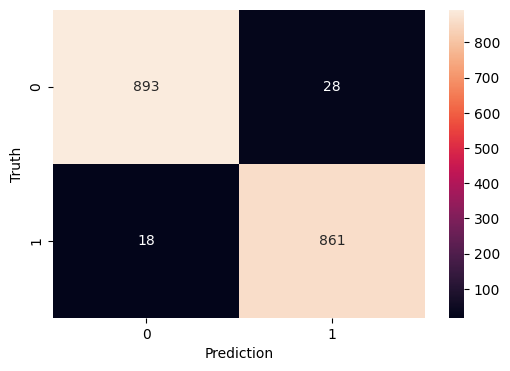

In [31]:
#finally print the confusion matrix for the best model
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (6,4))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')